# Simulation

<b>Step 1:</b> Randomly sample event type - Signal (S\Blue) or Noise (N\Orange)<br>
<b>Step 2:</b> Randomly sample human, system stimulus from the relevant distribution - stimulus ~N($\frac{d}{2},1)$ if the event is Signal and ~N($-\frac{d}{2},1)$ if the event is Noise<br>
<b>Step 3:</b> Compute the probability to the stimulus value giving it's Signal\Noise:
$$P(Stimulus|Signal)=norm.pdf(stimulus, \mu=\frac{d}{2},\sigma=1)$$
$$P(Stimulus|Noise)=norm.pdf(stimulus, \mu=-\frac{d}{2}, \sigma=1$$<br>

<b>Step 4:</b> Compute the probability to Signal\Noise giving the human stimulus:
$$P(Signal|Stimulus_h)^{*}=\frac{P(Stimulus_h|Signal)\cdot{P(S)}}{P(Stimulus_h|Signal)\cdot{P(S)} + P(Stimulus_h|Noise)\cdot{P(N)}}$$
$$P(Noise|Stimulus_h)=1 - P(Signal|Stimulus_h)$$

<b>Step 4:</b> To compute the probability to signal, giving the human and system stimulus:

$$P(Signal|Stimulus_{s},Stimulus_{h})=\frac{P(Stimulus_s|Signal)\cdot{*}}{P(Stimulus_s|Signal)\cdot{*} + (1-*)\cdot{P(Stimulus|Noise)}}$$

<b>Step 5:</b> Compute the Exepected Value (EV) of the human giving the stimulus.<br>After seeing the stimulus the human has more information and we should use $P(Signal|Stimulus)$ instead of the prior probability to signal event $P_{s}$<br>

<b>Step 6:</b> Compute EV with human and system togehther, also here, the human already has information about the event.<br>If the information is very clear ($P(Signal|Stimulus)$ is close to 0 or 1), the system can contribute little if any (depends on the system $d^{'})$.<br>However if the information is not helpfull ($P(Signal|Stimulus)$ is close the prior probability $P_{s}$), the human might choose to purchase additional information.<br>The decision whether to purchase the information depends on the quality of the additional information ($d^{'}$) and the cost to purchase it.

## Imports

In [1]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import pandas as pd
import numpy as np
import scipy.stats
import random
import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Simulation Parameters

In [2]:
P_blue = 0.5
d_h = 1.5
d_s = 20
d_s_low = .75
d_s_high = 2.25
system_cost = .1
payoffs = {'VTP': 2, 'VFP': -2, 'VFN': -2, 'VTN': 2}

## Aid Functions

### Signal Detection Theory Equations

##### Compute the ratio between the payoffmatrix
$\frac{V_{FP}-V_{TN}}{V_{FN}-V_{TP}}$

In [3]:
def payoff_ratio(payoffs):
    return (payoffs['VFP']-payoffs['VTN'])/(payoffs['VFN']-payoffs['VTP'])

##### Compute optimal Beta based on Ps and Vratio
$\frac{1-P_{s}}{P_{s}} \cdot \frac{V_{FP}-V_{TN}}{V_{FN}-V_{TP}}$

In [4]:
def beta(Ps, payoffs):
    return ((1-Ps) / Ps) * payoff_ratio(payoffs)

##### Compute Classification probabilities - $TPR, FPR, FNR, TNR$

In [5]:
def outcomes(d, payoffs=payoffs, Ps=P_blue, b=0):
    if b==0:
        b = beta(Ps, payoffs)                           # Beta based on Eq (1)
    c = np.log(b) / d                                   # Calculating c based on Beta and d'
    return {"PTP": 1-norm.cdf(c, loc=d/2),
            "PFP": 1-norm.cdf(c, loc=-d/2),
            "PFN": norm.cdf(c, loc=d/2),
            "PTN": norm.cdf(c, loc=-d/2)}

##### Compute conditional probabilities - $P(S|A), P(S|NA)...$

In [6]:
def p_cond(Ps, p):
    Pn = 1 - Ps
    return {"P(S|A)": (Ps * p["PTP"]) / (Ps*p["PTP"] + Pn*p["PFP"]),
            "P(N|A)": 1 - ((Ps * p["PTP"]) / (Ps*p["PTP"] + Pn*p["PFP"])),
            "P(S|NA)": (Ps * p["PFN"]) / (Ps*p["PFN"] + Pn*p["PTN"]),
            "P(N|NA)": 1 - ((Ps * p["PFN"]) / (Ps*p["PFN"] + Pn*p["PTN"]))}

##### Compute probability to raise an alarm
$P_{A} = \frac{P_{s}\cdot P_{TP}^{system}}{{P_{s}\cdot P_{TP}^{system}} + {P_{n}\cdot P_{FP}^{system}}}$

In [7]:
def p_alarm(Ps, p_sys):
    Pn = 1 - Ps
    return {'P_a':  Ps * p_sys["PTP"] + Pn * p_sys["PFP"],
            'P_na': Ps * p_sys["PFN"] + Pn * p_sys["PTN"]}

In [8]:
c = np.log(beta(P_blue, payoffs))/d_h
print(c)

0.0


### Expected Value (EV)

##### Compute Expected Value (EV) for human alone
$EV(\beta^{H|Stimulus}) = P_{s}\cdot (P_{TP}\cdot V_{TP} + P_{FN}\cdot V_{FN}) + P_{n}\cdot (P_{FP}\cdot V_{FP} + P_{TN}\cdot V_{TN})$<br>
The human classification probabilities are computed based on the stimulus, we are not using the prior probability to signal but the probability given the stimulus

In [9]:
def ev_h(Ps, d, payoffs = payoffs):
    p_h = outcomes(d, payoffs=payoffs, Ps=Ps)
    EV = \
        Ps     * (p_h['PTP'] * payoffs['VTP'] + p_h['PFN'] * payoffs['VFN']) + \
        (1-Ps) * (p_h['PFP'] * payoffs['VFP'] + p_h['PTN'] * payoffs['VTN'])
    return EV

##### Compute Expected Value (EV) for human and system
$    EV(\beta^{CDSS},\beta_{A}^{H|Stimulus},\beta_{\bar{A}}^{H|Stimulus}) = \\
    p_{A}\cdot[P(S|A)\cdot(P_{TP|A}^{H}\cdot V_{TP} + P_{FN|A}^{H}\cdot V_{FN})+P(N|A)\cdot(P_{FP|A}^{H}\cdot V_{FP} + P_{TN|A}^{H}\cdot V_{TN})]+\\
    p_{\bar{A}}\cdot[P(S|\bar{A})\cdot(P_{TP|\bar{A}}^{H}\cdot V_{TP} + P_{FN|\bar{A}}^{H}\cdot V_{FN})+                     P(N|\bar{A})\cdot(P_{FP|\bar{A}}^{H}\cdot V_{FP} + P_{TN|\bar{A}}^{H}\cdot V_{TN})]$
<br>
The human classification probabilities are computed based on the stimulus, which is different because the we are not using the prior probability to signal but the probability given the stimulus

In [10]:
def ev_h_s(Ps, d_h, d_s, payoffs, b = 0):
    p_sys = outcomes(d_s, payoffs, Ps=Ps, b=b)
    p_conditional = p_cond(Ps, p_sys)
    p_a = p_alarm(Ps, p_sys)
    p_h_a = outcomes(d_h, payoffs, Ps=p_conditional['P(S|A)'])
    p_h_na = outcomes(d_h, payoffs, Ps=p_conditional['P(S|NA)'])
    
    sum_prob = p_a['P_a'] *  (p_conditional['P(S|A)'] * (p_h_a['PTP'] + p_h_a['PFN']) +\
                              p_conditional['P(N|A)'] * (p_h_a['PFP'] + p_h_a['PTN'])) + \
               p_a['P_na'] * (p_conditional['P(S|NA)'] * (p_h_na['PTP'] + p_h_na['PFN']) + \
                              p_conditional['P(N|NA)'] * (p_h_na['PFP'] + p_h_na['PTN']))
    if round(sum_prob,3) != 1:
        print('problem')
    EV = p_a['P_a'] *  (p_conditional['P(S|A)'] * (p_h_a['PTP'] * payoffs['VTP'] + p_h_a['PFN'] * payoffs['VFN']) + \
                      p_conditional['P(N|A)'] * (p_h_a['PFP'] * payoffs['VFP'] + p_h_a['PTN'] * payoffs['VTN'])) + \
      p_a['P_na'] * (p_conditional['P(S|NA)'] * (p_h_na['PTP'] * payoffs['VTP'] + p_h_na['PFN'] * payoffs['VFN']) + \
                      p_conditional['P(N|NA)'] * (p_h_na['PFP'] * payoffs['VFP'] + p_h_na['PTN'] * payoffs['VTN']))
    return EV

### Responsibility

Based on Theli's coefficent - the relative reduction in the uncertainty of a variable X (Human) due to the knowledge of another variable Y (Automation).
ResQue model is the remaining relative uncertainty, given the knowledge about other variables

Without the automation the entropy is <b>$H(X)$</b>, with the automation the entropy is lower, because more information means less uncertainty <b>$H(X|Y) < H(X)$</b>.<br>
The reduction in the enropy due to the use of the automation is the automation's responsibility -> <b>$Resp Automation = \frac{H(X) - H(X|Y)}{H(X)}$</b> hence, the human responsibility is <b>$1-RespAutomation = \frac{H(X|Y)}{H(X)}$</b>

In [11]:
def prob(Ps, d_h=d_h, d_s=d_s, payoffs=payoffs):
    p_sys = outcomes(d_s, payoffs, Ps=Ps)                        # system classification probabilities
    p_conditional = p_cond(Ps, p_sys)                            # real event type given system output
    p_h_a = outcomes(d_h, payoffs, Ps=p_conditional['P(S|A)'])   # Human classification probabilities given system output A
    p_h_na = outcomes(d_h, payoffs, Ps=p_conditional['P(S|NA)']) # Human classification probabilities given system output NA
    p_a = p_alarm(Ps, p_sys)
    Pn = 1 - Ps
        
    xy = {                                                              # Table II
        "Alarm": {
            "Signal":  Ps * p_sys['PTP'] * p_h_a['PTP'] + Pn * p_sys['PFP'] * p_h_a['PFP'],
            "Noise":   Ps * p_sys['PTP'] * p_h_a['PFN'] + Pn * p_sys['PFP'] * p_h_a['PTN']
                },
        "No Alarm": {
            "Signal": Ps * p_sys['PFN'] * p_h_na['PTP'] + Pn * p_sys['PTN'] * p_h_na['PFP'],
            "Noise":  Ps * p_sys['PFN'] * p_h_na['PFN'] + Pn * p_sys['PTN'] * p_h_na['PTN']
                }
    }
    y = {"Alarm": xy["Alarm"]["Noise"] + xy["Alarm"]["Signal"],      # Table I
         "No Alarm":  xy["No Alarm"]["Noise"] + xy["No Alarm"]["Signal"]}

    x = {"Noise": xy["Alarm"]["Noise"] + xy["No Alarm"]["Noise"],
         "Signal": xy["Alarm"]["Signal"] + xy["No Alarm"]["Signal"]}      # Table III
    return x, y, xy, p_sys, p_h_a, p_h_na

In [12]:
def entropy(p):                                         # Calculating entropy of a single event
    return -sum([p[i]*np.log2(p[i]) if p[i] != 0 else 0 for i in p])

def joint_entropy(p):                                   # Calculating joint entropy of two events
    return -sum([sum([p[i][j]*np.log2(p[i][j]) if p[i][j] != 0 else 0 for j in p[i]]) for i in p])

def conditional_entropy(p,p1):                          # Calculating conditional entropy of two events
    return -sum([sum([p[i][j]*np.log2(p[i][j]/p1[i]) if p[i][j] != 0 else 0 for j in p[i]]) for i in p])

In [13]:
def responsibility(Ps, d_h=d_h, d_s=d_s, payoffs=payoffs):
    x, y, xy, p_sys, p_h_a, p_h_na = prob(Ps, d_h, d_s, payoffs)
    return conditional_entropy(xy,y) / entropy(x)
    return (joint_entropy(xy) - entropy(y)) / entropy(x)

### Visualization

In [14]:
def plot(df, color='black', l = '', cost = system_cost, legend = False, stimulus = "stimulus_h"):
    ax=sns.scatterplot(x=df[df['event']=='S'][stimulus],y=df[df['event']=='S']['P(stimulus_h|S)'],color=color,label=l)
    ax=sns.scatterplot(x=df[df['event']=='N'][stimulus],y=df[df['event']=='N']['P(stimulus_h|N)'],color=color)
#     ax=sns.lineplot(x=[df.stimulus.min()]*2, y=[0,.4])
#     ax=sns.lineplot(x=[df.stimulus.max()]*2, y=[0,.4])
    ax.text(-3.5, .38,f"Cost={cost}", fontsize=12)
    ax.text(.3, .42,f"Signal", fontsize=12)
    ax.text(-1.2, .42,f"Noise", fontsize=12)
    ax.set_xlim(-4,4)
    ax.set_ylim(0,.45)
    if not legend:
        plt.legend([])

In [15]:
x, y, xy, p_sys, p_h_a, p_h_na = prob(P_blue, d_h=d_h, d_s=d_s, payoffs=payoffs)
print('--------------------Effective Probabilities--------------------')
print(f'{xy}')
print('--------------------System Probabilities--------------------')
print(f'{p_sys}')
print('--------------------Human Probabilities Given Alarm--------------------')
print(f'{p_h_a}')
print('--------------------Human Probabilities Given No Alarm--------------------')
print(f'{p_h_na}')

--------------------Effective Probabilities--------------------
{'Alarm': {'Signal': 0.5, 'Noise': 0.0}, 'No Alarm': {'Signal': 0.0, 'Noise': 0.5}}
--------------------System Probabilities--------------------
{'PTP': 1.0, 'PFP': 0.0, 'PFN': 7.61985302416047e-24, 'PTN': 1.0}
--------------------Human Probabilities Given Alarm--------------------
{'PTP': 1.0, 'PFP': 1.0, 'PFN': 0.0, 'PTN': 0.0}
--------------------Human Probabilities Given No Alarm--------------------
{'PTP': 0.0, 'PFP': 0.0, 'PFN': 1.0, 'PTN': 1.0}


/var/folders/cg/6ygtmwqx3pz5c378p9rj2c9w0000gn/T/ipykernel_87073/497509122.py:4: RuntimeWarning: divide by zero encountered in log
  c = np.log(b) / d                                   # Calculating c based on Beta and d'


## Simulation

In [16]:
print(norm.pdf(0.1173132, -d_s_low/2, 1))
print(norm.pdf(0.8673132, -d_s_high/2, 1))

0.353410617159456
0.05482579540831686


In [17]:
block_trial_design = {1: 16, 2: 16, 3: 50}

In [18]:
def Simulation(P_blue = P_blue, d_h = d_h, d_s_low = d_s_low, d_s_high = d_s_high, payoffs = payoffs):
  
    data = {'block': [], 'trial': [], 'event': [],
            'stimulus_h': [], 'stimulus_s_low': [], 'stimulus_s_high': [], 
            'P(stimulus_h|Blue)': [], 'P(stimulus_s_low|Blue)': [], 'P(stimulus_s_high|Blue)': [],
            'P(Blue|stimulus_h)': [], 'P(Blue|stimulus_s_low)': [], 'P(Blue|stimulus_s_high)': [],
            
            'P(stimulus_h|Orange)': [], 'P(Orange|stimulus_h)': [],
            'P(stimulus_s_low|Orange)': [],'P(Orange|stimulus_s_low)': [],
            'P(stimulus_s_high|Orange)': [],'P(Orange|stimulus_s_high)': [], 
            
            'P(Human)': [],'P(Low_System_Binary)': [],'P(Low_System_Likelihood)': [],
            'P(Low_System_Integrated)': [],
                           'P(High_System_Binary)': [],'P(High_System_Likelihood)': [],
            'P(High_System_Integrated)': []} 
    
    for block_number in block_trial_design.keys():
        blues, oranges = 0, 0
        for trial_number in range(1,block_trial_design[block_number]+1):
            human_stimulus = np.random.normal(0, 1)      # sample the human stimulus
            system_stimulus = np.random.normal(0, 1)     # sample the system stimulus
            p = np.random.uniform(0,1)                   # samlple blue or orange
            # if it is blue, we should sample from the blue dist
            if p < P_blue and blues < int(block_trial_design[block_number]/2):
                blues += 1
                human_stimulus += d_h/2                  
                low_system_stimulus = system_stimulus + d_s_low/2
                high_system_stimulus = system_stimulus + d_s_high/2
                blue_or_orange = 'Blue'
            # if it is orange, we should sample from the orange dist
            elif p >= P_blue and oranges < int(block_trial_design[block_number]/2):
                oranges += 1
                human_stimulus -= d_h/2                  
                low_system_stimulus = system_stimulus - d_s_low/2
                high_system_stimulus = system_stimulus - d_s_high/2
                blue_or_orange = 'Orange'
            elif blues < int(block_trial_design[block_number]/2):
                blues += 1
                human_stimulus += d_h/2                  
                low_system_stimulus = system_stimulus + d_s_low/2
                high_system_stimulus = system_stimulus + d_s_high/2                 
                blue_or_orange = 'Blue'
            elif oranges < int(block_trial_design[block_number]/2):
                oranges += 1
                human_stimulus -= d_h/2                  
                low_system_stimulus = system_stimulus - d_s_low/2
                high_system_stimulus = system_stimulus - d_s_high/2
                blue_or_orange = 'Orange'   
            else:
                print(problem)

            ###--Human Stimulus & Probabilities--###
            # Compute the probability of getting this stimulus in the blue distribution
            p_stimulus_given_blue_h = norm.pdf(human_stimulus, d_h/2, 1)
            # Compute the probability of gerrting this stimulus in the orange distribution
            p_stimulus_given_orange_h  = norm.pdf(human_stimulus, -d_h/2, 1)
            # Compute the probability for the event beeing blue giving the stimulus (using base)
            p_blue_given_stimulus_h = (P_blue*p_stimulus_given_blue_h)/\
                                      (P_blue*p_stimulus_given_blue_h + (1-P_blue)*p_stimulus_given_orange_h)
            p_orange_given_stimulus_h  = 1-p_blue_given_stimulus_h


            ###--System Stimulus & Probabilities--###
            # Compute the probability of getting this stimulus in the blue distribution
            p_stimulus_given_blue_s_low = norm.pdf(low_system_stimulus, d_s_low/2, 1)
            p_stimulus_given_blue_s_high = norm.pdf(high_system_stimulus, d_s_high/2, 1)
            # Compute the probability of gerrting this stimulus in the orange distribution
            p_stimulus_given_orange_s_low  = norm.pdf(low_system_stimulus, -d_s_low/2, 1)
            p_stimulus_given_orange_s_high  = norm.pdf(high_system_stimulus, -d_s_high/2, 1)
            # Compute the probability for the event beeing blue giving the stimulus
            p_blue_given_stimulus_s_low = (P_blue*p_stimulus_given_blue_s_low)/\
                                      ((1-P_blue)*p_stimulus_given_orange_s_low+P_blue*p_stimulus_given_blue_s_low)
            p_orange_given_stimulus_s_low  = 1-p_blue_given_stimulus_s_low
            p_blue_given_stimulus_s_high = (P_blue*p_stimulus_given_blue_s_high)/\
                                      ((1-P_blue)*p_stimulus_given_orange_s_high+P_blue*p_stimulus_given_blue_s_high)
            p_orange_given_stimulus_s_high  = 1-p_blue_given_stimulus_s_high

            ###--Integrated Probability--###
            p_blue_integarted_low = (p_blue_given_stimulus_h*p_stimulus_given_blue_s_low)/\
                                      (p_blue_given_stimulus_h*p_stimulus_given_blue_s_low+\
                                       p_orange_given_stimulus_h*p_stimulus_given_orange_s_low)
            p_orange_integarted_low  = 1-p_blue_integarted_low
            p_blue_integarted_high = (p_blue_given_stimulus_h*p_stimulus_given_blue_s_high)/\
                                      (p_blue_given_stimulus_h*p_stimulus_given_blue_s_high+\
                                       p_orange_given_stimulus_h*p_stimulus_given_orange_s_high)
            p_orange_integarted_high  = 1-p_blue_integarted_high            

            if low_system_stimulus < np.log(beta(P_blue, payoffs))/d_s_low:
                low_system_output = 'Orange'
            else:
                low_system_output = 'Blue'
            if high_system_stimulus < np.log(beta(P_blue, payoffs))/d_s_high:
                high_system_output = 'Orange'
            else:
                high_system_output = 'Blue'
        
            ###--Add Data For System Dataframe--###
            data['block'].append(block_number)
            data['trial'].append(trial_number)                        
            data['event'].append(blue_or_orange)
            data['stimulus_h'].append(human_stimulus)
            data['stimulus_s_low'].append(low_system_stimulus)
            data['stimulus_s_high'].append(high_system_stimulus)
            data['P(stimulus_h|Blue)'].append(p_stimulus_given_blue_h)
            data['P(stimulus_s_low|Blue)'].append(p_stimulus_given_blue_s_low)
            data['P(stimulus_s_high|Blue)'].append(p_stimulus_given_blue_s_high)
            data['P(Blue|stimulus_h)'].append(p_blue_given_stimulus_h)
            data['P(Blue|stimulus_s_low)'].append(p_blue_given_stimulus_s_low)
            data['P(Blue|stimulus_s_high)'].append(p_blue_given_stimulus_s_high)
            
            data['P(stimulus_h|Orange)'].append(p_stimulus_given_orange_h)
            data['P(Orange|stimulus_h)'].append(p_orange_given_stimulus_h)            
            data['P(stimulus_s_low|Orange)'].append(p_stimulus_given_orange_s_low)
            data['P(Orange|stimulus_s_low)'].append(p_orange_given_stimulus_s_low)                     
            data['P(stimulus_s_high|Orange)'].append(p_stimulus_given_orange_s_high)
            data['P(Orange|stimulus_s_high)'].append(p_orange_given_stimulus_s_high)
            
            data['P(Human)'].append(p_blue_given_stimulus_h)
            data['P(Low_System_Binary)'].append(low_system_output)
            data['P(Low_System_Likelihood)'].append(p_blue_given_stimulus_s_low)
            data['P(Low_System_Integrated)'].append(p_blue_integarted_low)    
            
            data['P(High_System_Binary)'].append(high_system_output)
            data['P(High_System_Likelihood)'].append(p_blue_given_stimulus_s_high)
            data['P(High_System_Integrated)'].append(p_blue_integarted_high)
                          
    df = pd.DataFrame(list(zip(data['block'], data['trial'], data['event'], data['stimulus_h'],
                               data['stimulus_s_low'],data['stimulus_s_high'],
                               data['P(stimulus_h|Blue)'],
                               data['P(stimulus_s_low|Blue)'], data['P(stimulus_s_high|Blue)'],
                               data['P(Blue|stimulus_h)'],
                               data['P(Blue|stimulus_s_low)'], data['P(Blue|stimulus_s_high)'],
                               
                               data['P(stimulus_h|Orange)'], data['P(Orange|stimulus_h)'],
                               data['P(stimulus_s_low|Orange)'], data['P(Orange|stimulus_s_low)'],
                               data['P(stimulus_s_high|Orange)'], data['P(Orange|stimulus_s_high)'],
                               
                               data['P(Human)'],
                               data['P(Low_System_Binary)'], data['P(Low_System_Likelihood)'],
                               data['P(Low_System_Integrated)'],
                               data['P(High_System_Binary)'], data['P(High_System_Likelihood)'],
                               data['P(High_System_Integrated)'])),
                        columns = data.keys())
    
    if round(df['P(Human)'].mean(),1) != P_blue:
        print('---------------Problem---------------')
        df = Simulation()
    return df

In [19]:
def confusion_matrix(df, d):
    tp = df[(df[f'P({d}System_Binary)']=='Blue')&(df['event']=='Blue')].shape[0]
    tn = df[(df[f'P({d}System_Binary)']=='Orange')&(df['event']=='Orange')].shape[0]
    fp = df[(df[f'P({d}System_Binary)']=='Blue')&(df['event']=='Orange')].shape[0]
    fn = df[(df[f'P({d}System_Binary)']=='Orange')&(df['event']=='Blue')].shape[0]
    tpr = round(tp/(tp+fn), 2)
    fnr = round(fn/(tp+fn), 2)
    fpr = round(fp/(fp+tn), 2)
    tnr = round(tn/(fp+tn), 2)
    return tpr, tnr, fpr, fnr

In [20]:
def main(P_blue = P_blue, d_h = d_h, d_s_low = d_s_low, d_s_high = d_s_high, payoffs = payoffs):
    stop = False
    index = 0
    cause = 0
    while not stop:
        clear_output(wait=True)
        print(index, cause)
        index += 1
        df = Simulation()
        tpr_low, tnr_low, fpr_low, fnr_low = confusion_matrix(df, 'Low_')
        tpr_high, tnr_high, fpr_high, fnr_high = confusion_matrix(df, 'High_')
        mean_accuracy_low = round(np.mean([tpr_low, tnr_low]),2)
        mean_accuracy_high = round(np.mean([tpr_high, tnr_high]),2)
        std_accuracy_low = round(np.std([tpr_low, tnr_low]),2)
        std_accuracy_high = round(np.std([tpr_high, tnr_high]),2)
        if df[(df['block'] == 1) & (df['event'] == 'Blue')].shape[0] != int(block_trial_design[1]/2):
            cause = 1
            continue
        if df[(df['block'] == 2) & (df['event'] == 'Blue')].shape[0] != int(block_trial_design[2]/2):
            cause = 2
            continue            
        if df[(df['block'] == 3) & (df['event'] == 'Blue')].shape[0] != int(block_trial_design[3]/2):
            cause = 3
            continue                           
        #tpr_low + tnr_low tpr_low != .65 or tnr_low != .65:
        if (mean_accuracy_low > .66 or mean_accuracy_low < .64) or std_accuracy_low > .01:
            cause = f"5: TNR={tnr_low}, TPR={tpr_low}, M={mean_accuracy_low}, SD={std_accuracy_low}"
            continue   
        #tpr_high != .87 or tnr_high != .87:
        if (mean_accuracy_high > .88 or mean_accuracy_high < .86) or std_accuracy_high > .01:
            cause = f"6: TNR={tnr_high}, TPR={tpr_high}, M={mean_accuracy_high}, SD={std_accuracy_high}"
            continue               
        stop = True
    clear_output(wait=True)
    signals = df[(df['event'] == 'Blue')].shape[0]
    print(index)
    print(f"Blue events: {df[(df['event']=='Blue')].shape[0]}, Orange events: {df[(df['event']=='Orange')].shape[0]}")
    print(f"Low --> TPR: {tpr_low}; FPR: {fpr_low}; FNR: {fnr_low}; TNR: {tnr_low}")
    print(f"High --> TPR: {tpr_high}; FPR: {fpr_high}; FNR: {fnr_high}; TNR: {tnr_high}")
    return df

In [21]:
print(f"Low -->: TPR: {round(outcomes(d_s_low)['PTP'],2)}, TNR: {round(outcomes(d_s_low)['PTN'],2)}")
print(f"High -->: TPR: {round(outcomes(d_s_high)['PTP'],2)}, TNR: {round(outcomes(d_s_high)['PTN'],2)}")

Low -->: TPR: 0.65, TNR: 0.65
High -->: TPR: 0.87, TNR: 0.87


In [22]:
data = main()

1626
Blue events: 41, Orange events: 41
Low --> TPR: 0.66; FPR: 0.34; FNR: 0.34; TNR: 0.66
High --> TPR: 0.88; FPR: 0.12; FNR: 0.12; TNR: 0.88


In [23]:
# data.to_csv('events.csv', index = False)

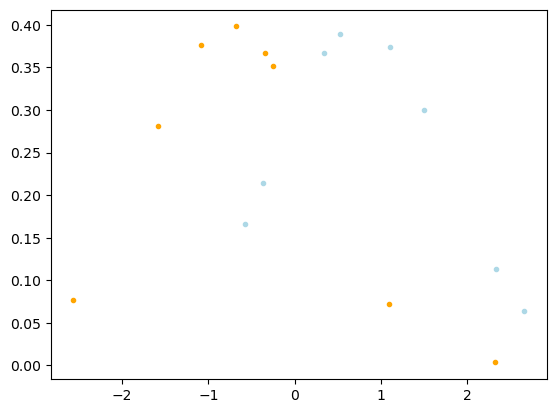

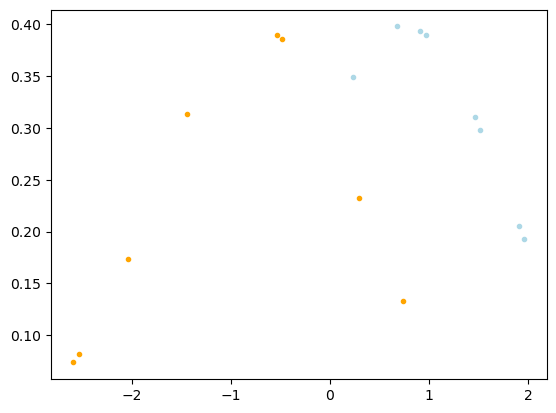

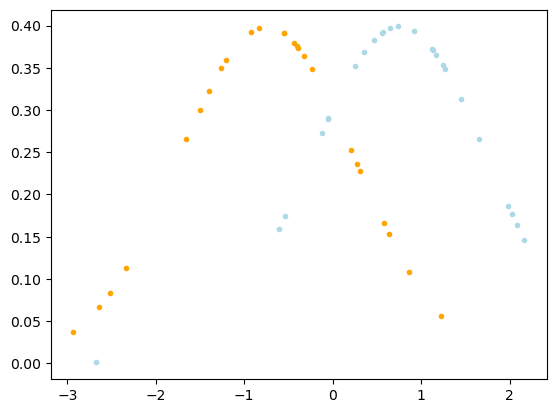

In [24]:
for block in block_trial_design.keys():
    for color in ['Blue','Orange']:
        part_df = data[(data['event'] == color) & (data['block'] == block)]
        if color == 'Blue':
            plt.plot(part_df['stimulus_h'], part_df['P(stimulus_h|Blue)'], '.', color = 'lightBlue')
        else:        
            plt.plot(part_df['stimulus_h'], part_df['P(stimulus_h|Orange)'], '.', color = 'Orange')
    plt.show()

$$P(Signal|Stimulus)=\frac{P(Stimulus|Signal)\cdot{P(S)}}{P(Stimulus|Signal)\cdot{P(S)} + P(Stimulus|Noise)\cdot{P(N)}}$$